# <font  color = "#0093AF"> Solid Effect

## Setup

In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build spin system
It is critical to note that solid-effect relies on terms in the Hamiltonian that tilt the nuclear spin away from the z-axis. That is, the nucleus must be treated in the lab frame. On the other hand, we need to irradiate the electron, so we would rather leave it in the rotating frame. Then, we set the frames for the spins individually.

In [81]:
ex=sl.ExpSys(v0H=600,Nucs=['e-','1H'],LF=[False,True],vr=5000,T_K=80,pwdavg=sl.PowderAvg(q=2))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-1000000,Ayy=-1000000,Azz=2000000)
_=ex.set_inter('g',i=0,gxx=2.0027,gyy=2.0031,gzz=2.0034,euler=[0,0,0])

In [82]:
L=ex.Liouvillian()
L.add_relax(Type='T2',i=0,T2=.890e-6)
L.add_relax(Type='T2',i=1,T2=5e-3)
L.add_relax(Type='T1',i=0,T1=1.4e-3)
L.add_relax(Type='T1',i=1,T1=10)
_=L.add_relax(Type='recovery')

In [83]:
seq=L.Sequence()
_=seq.add_channel(channel='e-',v1=1e6,voff=589e6)

In [84]:
rho=sl.Rho(rho0='ez',detect='1Hz')

In [85]:
rho.clear()
U=seq.U()**100  #100 rotor periods per step
_=rho.DetProp(U,n=2000)

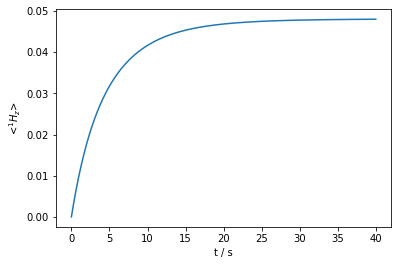

In [86]:
ax=rho.plot(axis='s')

We can compare this to the $^1$H buildup without electron irradiation to observe a significant encancement.

In [54]:
print(f'Enhancement: {rho.I[0][-1].real/ex.Peq[1]:.0f}')

Enhancement: 267


## Behavior during a rotor period
It is interesting to note that the efficient of DNP under MAS comes in large part because the rotor spinning sweeps us through the matching conditions. Here, we select just one crystallite from our powder average, and simulate one rotor period with 100 steps, to observe the time dependence of the enhancement throughout the rotor period.

Prop: 100 steps per every 1 rotor period


<AxesSubplot:xlabel='t / s', ylabel='<$^{1}H_z$>'>

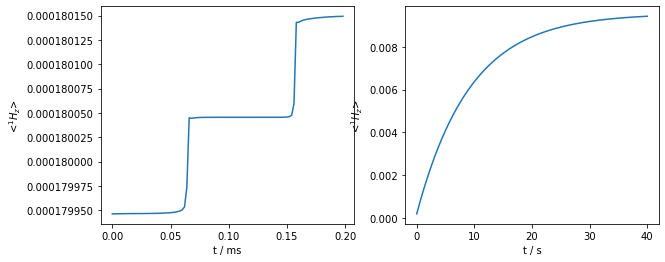

In [79]:
ex_cr=sl.ExpSys(v0H=600,Nucs=['e-','1H'],LF=[False,True],vr=5000,T_K=80,pwdavg=sl.PowderAvg(q=2)[10])
ex_cr.set_inter('hyperfine',i0=0,i1=1,Axx=-1000000,Ayy=-1000000,Azz=2000000)
ex_cr.set_inter('g',i=0,gxx=2.0027,gyy=2.0031,gzz=2.0034,euler=[0,0,0])

L=ex_cr.Liouvillian()
L=ex_cr.Liouvillian()
L.add_relax(Type='T2',i=0,T2=.890e-6)
L.add_relax(Type='T2',i=1,T2=5e-3)
L.add_relax(Type='T1',i=0,T1=1.4e-3)
L.add_relax(Type='T1',i=1,T1=10)
_=L.add_relax(Type='recovery')

seq=L.Sequence()
_=seq.add_channel(channel='e-',v1=1e6,voff=589e6)
rho=sl.Rho('Thermal','1Hz')

_,ax=plt.subplots(1,2,figsize=[10,4])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.plot(ax=ax[0])
rho.clear()
U=seq.U()**100
rho.DetProp(U,n=2000)
rho.plot(ax=ax[1],axis='s')

We see that the solid-effect condition is hit twice per rotor period. If we only sample every 100 rotor periods, we just see the smooth buildup.

## Generate a field profile
We may also sweep through the solid effect condition (we just do one side) to see where the best matching condition is obtained.

In [87]:
rho=sl.Rho(rho0='Thermal',detect='1Hz')

offset=np.linspace(550e6,650e6,51)

I=[]
for k,offset0 in enumerate(offset):
    rho.clear()
    seq=L.Sequence()
    seq.add_channel(channel='e-',v1=1e6,voff=offset0)
    U=seq.U()**(5*1000*10)
    (U*rho)()
    I.append(rho.I[0,0])
    if np.mod(k,10)==0:print(k)

0
10
20
30
40
50


Text(0.5, 0, '$\\Delta\\nu_e / MHz$')

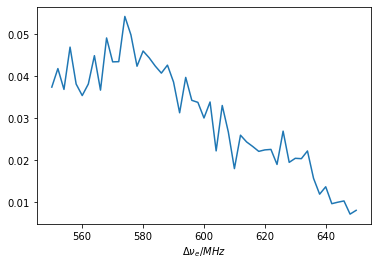

In [88]:
ax=plt.subplots()[1]
ax.plot(offset/1e6,np.array(I).real)
ax.set_xlabel(r'$\Delta\nu_e / MHz$')